In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import yaml
import sys
from torch.utils.data import Dataset
import torchvision
from torch.utils.data import DataLoader
sys.path.append("../")
from src.utils import DatasetSplit, setup_seed, mkdirs, get_datasets, Spiral, MulGaussian
from matplotlib import pyplot as plt
import math
from matplotlib import cm
from collections import Counter
import math

# Defind a MLP classifier

In [8]:
class MLP(nn.Module):
    def __init__(self, dim, num_cls, W=None):
        self.dim = dim
        super().__init__()
        self.fc1 = nn.Linear(2, dim * 8)
        self.fc2 = nn.Linear(dim * 8, dim * 4)
        self.fc3 = nn.Linear(dim * 4, dim * 2)
        self.fc4 = nn.Linear(dim * 2, dim)
        if W is None:
            temp = nn.Linear(dim, num_cls, bias=False).state_dict()['weight']
            self.W = nn.Parameter(temp)
        else:
            self.W = W
    def forward(self, x, normalize=False, return_embedding=False):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        feature_embedding = self.fc4(x)
        if normalize:
            feature_embedding_norm = torch.norm(feature_embedding, p=2, dim=1, keepdim=True).clamp(min=1e-12)
            feature_embedding = torch.div(feature_embedding, feature_embedding_norm)
            W_norm = torch.norm(self.W, p=2, dim=1, keepdim=True).clamp(min=1e-12)
            normalized_W = torch.div(self.W, W_norm)
            logits = torch.matmul(feature_embedding, normalized_W.T)
        else:
            logits = torch.matmul(feature_embedding, self.W.T)
            
        if return_embedding:
            return feature_embedding, logits
        return logits  

# A visualization helper function

In [9]:
def vis(dataset, normalize):
    x1, x2, y = [], [], []
    cst_max = 0
    color_dict = {}
    for i in range(len(dataset)):
        temp = dataset[i]
        cst = torch.norm(temp[0]).item()
        if cst > cst_max:
            cst_max = cst
        if normalize:
            x1.append(temp[0][0].item()/cst)
            x2.append(temp[0][1].item()/cst)
        else:
            x1.append(temp[0][0].item())
            x2.append(temp[0][1].item())
        y.append(temp[1].item())
    fig = plt.scatter(x1, x2, c=y, cmap=cm.nipy_spectral)
    legend = plt.legend(*fig.legend_elements(), loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fancybox=True, prop={'size': 5})
    plt.gca().set_aspect('equal')
    for idx, cls in enumerate(y):
        if cls not in color_dict:
            color_dict[cls] =  fig.to_rgba(y[idx])

# Balanced Case

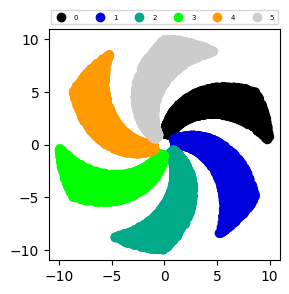

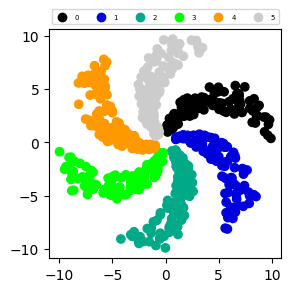

In [10]:
setup_seed(2022)
ntrain, ntest = 3000, 100
num_cls = 6
n_lst = [ntrain for k in range(num_cls)]
trainset = Spiral(n_lst)
testset =Spiral([ntest] * num_cls)
plt.figure(figsize=(3,3))
vis(trainset, False)

plt.figure(figsize=(3,3))
vis(testset, False)
trainloader = DataLoader(trainset, batch_size=min(5000, sum(n_lst)), shuffle=True)
testloader = DataLoader(testset, batch_size=ntest*num_cls, shuffle=False)

## Trainable head

In [5]:
lr_init = 0.1; device='cuda:1'; print_freq = 100; verbose=True
setup_seed(2022)
net = MLP(2, num_cls).to(device)
for epoch in range(201):
    if epoch % print_freq == 0 and verbose:
        print("====") 
    epoch_loss = 0.0
    optimizer = torch.optim.SGD(net.parameters(), lr=lr_init * (0.99 ** epoch),
                                    momentum=0.9, weight_decay=1e-5)
    for it, data in enumerate(trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        logits = net(x, return_embedding=False)
        col_idx = y.view(-1,1)
        scores = torch.log(F.softmax(logits, dim=1)+1e-12)
        loss = -torch.mean(torch.gather(scores, dim=1, index=col_idx))  
        net.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        epoch_loss += loss.item() * x.shape[0]
    epoch_loss /= len(trainloader.dataset)
    if epoch % print_freq == 0 and verbose:
        print(f" epoch:{epoch:3d} | avg loss:{epoch_loss:.3e} ")
print("test")
with torch.no_grad():
    acc_dict = {cls:0 for cls in range(num_cls)}
    for it, data in enumerate(testloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        logits = net(x)
        pred = logits.max(1)[1]
        for i in range(len(y)):
            if pred[i].item() == y[i].item():
                acc_dict[y[i].item()] += 1
    print(acc_dict)                

====
 epoch:  0 | avg loss:1.815e+00 
====
 epoch:100 | avg loss:1.550e-02 
====
 epoch:200 | avg loss:7.658e-03 
test
{0: 98, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}


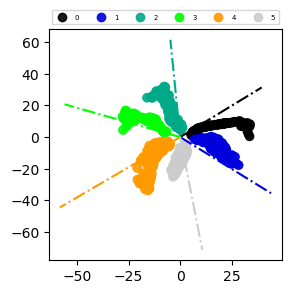

In [6]:
x, y = iter(testloader).next()
embedding, distance = net(x.to(device), return_embedding=True)
x = embedding
x1, x2, color = [], [], []
for i in range(len(y)):
    x1.append(x[i][0].item())
    x2.append(x[i][1].item())
    color.append(y[i].item())
    
plt.figure(figsize=(3,3))
fig = plt.scatter(x1, x2, c=color, cmap=cm.nipy_spectral,alpha=0.9)
legend = plt.legend(*fig.legend_elements(), loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fancybox=True, prop={'size': 5})
centers = net.W.detach().cpu()
# scale for the visualization purpose
scale = 40
for i in range(centers.shape[0]):
    x1, x2 = [0.0, scale*centers[i][0].item()], [0.0, scale*centers[i][1].item()]
    plt.plot(x1, x2,  '-.', color=fig.to_rgba(i)) 

## Uniform Head

In [7]:
r = 1.0
W = torch.zeros(num_cls,2)
for i in range(num_cls):
    theta = i*2*torch.pi/num_cls
    W[i,:] = torch.tensor([r*math.cos(theta), r*math.sin(theta)])

In [8]:
lr_init = 0.1; device='cuda:1'; verbose=True; print_freq = 100
setup_seed(2022)
net = MLP(2, num_cls, W=W.to(device)).to(device)
for epoch in range(201):
    if epoch % print_freq == 0 and verbose:
        print("====") 
    epoch_loss = 0.0
    optimizer = torch.optim.SGD(net.parameters(), lr=lr_init * (0.99 ** epoch),
                                    momentum=0.9, weight_decay=1e-5)
    for it, data in enumerate(trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        logits = net(x, return_embedding=False)
        col_idx = y.view(-1,1)
        scores = torch.log(F.softmax(logits, dim=1)+1e-12)
        loss = -torch.mean(torch.gather(scores, dim=1, index=col_idx))  
        net.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        epoch_loss += loss.item() * x.shape[0]
    epoch_loss /= len(trainloader.dataset)
    if epoch % print_freq == 0 and verbose:
        print(f" epoch:{epoch:3d} | avg loss:{epoch_loss:.3e} ")
        
print("test")
with torch.no_grad():
    acc_dict = {cls:0 for cls in range(num_cls)}
    for it, data in enumerate(testloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        logits = net(x)
        pred = logits.max(1)[1]
        for i in range(len(y)):
            if pred[i].item() == y[i].item():
                acc_dict[y[i].item()] += 1
    print(acc_dict)                

====
 epoch:  0 | avg loss:1.732e+00 
====
 epoch:100 | avg loss:8.963e-03 
====
 epoch:200 | avg loss:5.013e-03 
test
{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}


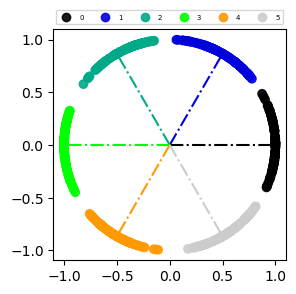

In [9]:
x, y = iter(testloader).next()
embedding, distance = net(x.to(device), normalize=True, return_embedding=True)
x = embedding
x1, x2, color = [], [], []
for i in range(len(y)):
    x1.append(x[i][0].item())
    x2.append(x[i][1].item())
    color.append(y[i].item())
plt.figure(figsize=(3,3))    
fig = plt.scatter(x1, x2, c=color, cmap=cm.nipy_spectral,alpha=0.9)
legend = plt.legend(*fig.legend_elements(), loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fancybox=True, prop={'size': 5})
centers = net.W.detach().cpu()
scale = 1
for i in range(centers.shape[0]):
    x1, x2 = [0.0, scale*centers[i][0].item()], [0.0, scale*centers[i][1].item()]
    plt.plot(x1, x2,  '-.', color=fig.to_rgba(i)) 

# Imbalanced Case

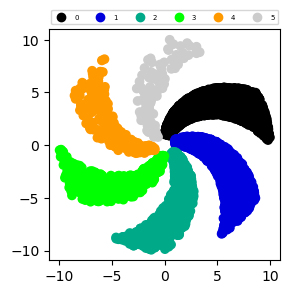

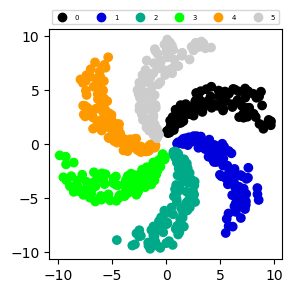

In [10]:
setup_seed(2022)
ntrain, ntest = 3000, 100
num_cls = 6
n_lst = [int(ntrain / (2.0**k)) for k in range(num_cls)]
trainset = Spiral(n_lst)
testset =Spiral([ntest] * num_cls)
plt.figure(figsize=(3,3))
vis(trainset, False)
plt.figure(figsize=(3,3))
vis(testset, False)
trainloader = DataLoader(trainset, batch_size=min(5000, sum(n_lst)), shuffle=True)
testloader = DataLoader(testset, batch_size=ntest*num_cls, shuffle=False)

## Trainable Head

In [11]:
lr_init = 0.1; device='cuda:1'; verbose=True; print_freq = 100
setup_seed(2022)
net = MLP(2, num_cls).to(device)
for epoch in range(201):
    if epoch % print_freq == 0 and verbose:
        print("====") 
    epoch_loss = 0.0
    optimizer = torch.optim.SGD(net.parameters(), lr=lr_init * (0.99 ** epoch),
                                    momentum=0.9, weight_decay=1e-5)
    for it, data in enumerate(trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        logits = net(x, return_embedding=False)
        col_idx = y.view(-1,1)
        scores = torch.log(F.softmax(logits, dim=1)+1e-12)
        loss = -torch.mean(torch.gather(scores, dim=1, index=col_idx))  
        net.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        epoch_loss += loss.item() * x.shape[0]
    epoch_loss /= len(trainloader.dataset)
    if epoch % print_freq == 0 and verbose:
        print(f" epoch:{epoch:3d} | avg loss:{epoch_loss:.3e} ")
print("test")
with torch.no_grad():
    acc_dict = {cls:0 for cls in range(num_cls)}
    for it, data in enumerate(testloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        logits = net(x)
        pred = logits.max(1)[1]
        for i in range(len(y)):
            if pred[i].item() == y[i].item():
                acc_dict[y[i].item()] += 1
    print(acc_dict)   

====
 epoch:  0 | avg loss:1.942e+00 
====
 epoch:100 | avg loss:4.295e-01 
====
 epoch:200 | avg loss:3.442e-01 
test
{0: 100, 1: 100, 2: 1, 3: 0, 4: 100, 5: 0}


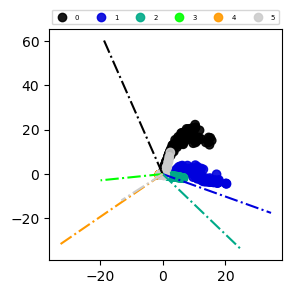

In [12]:
x, y = iter(testloader).next()
embedding, distance = net(x.to(device), return_embedding=True)
x = embedding
x1, x2, color = [], [], []
for i in range(len(y)):
    x1.append(x[i][0].item())
    x2.append(x[i][1].item())
    color.append(y[i].item())
plt.figure(figsize=(3,3))    
fig = plt.scatter(x1, x2, c=color, cmap=cm.nipy_spectral,alpha=0.9)
legend = plt.legend(*fig.legend_elements(), loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fancybox=True, prop={'size': 5})

centers = net.W.detach().cpu()
scale = 40
for i in range(centers.shape[0]):
    x1, x2 = [0.0, scale*centers[i][0].item()], [0.0, scale*centers[i][1].item()]
    plt.plot(x1, x2,  '-.', color=fig.to_rgba(i)) 

## Uniform Head

In [13]:
r = 1.0
W = torch.zeros(num_cls,2)
for i in range(num_cls):
    theta = i*2*torch.pi/num_cls
    W[i,:] = torch.tensor([r*math.cos(theta), r*math.sin(theta)])

In [16]:
lr_init = 0.1; device='cuda:1'; verbose=True; print_freq = 100
setup_seed(2022)
net = MLP(2, num_cls, W=W.to(device)).to(device)
for epoch in range(201):
    if epoch % print_freq == 0 and verbose:
        print("====") 
    epoch_loss = 0.0
    optimizer = torch.optim.SGD(net.parameters(), lr=lr_init * (0.99 ** epoch),
                                    momentum=0.9, weight_decay=1e-5)
    for it, data in enumerate(trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        logits = net(x, normalize=True, return_embedding=False)
        col_idx = y.view(-1,1)
        scores = torch.log(F.softmax(logits, dim=1)+1e-12)
        loss = -torch.mean(torch.gather(scores, dim=1, index=col_idx))  
        net.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        epoch_loss += loss.item() * x.shape[0]
    epoch_loss /= len(trainloader.dataset)
    if epoch % print_freq == 0 and verbose:
        print(f" epoch:{epoch:3d} | avg loss:{epoch_loss:.3e} ")
        
print("test")
with torch.no_grad():
    acc_dict = {cls:0 for cls in range(num_cls)}
    for it, data in enumerate(testloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        logits = net(x)
        pred = logits.max(1)[1]
        for i in range(len(y)):
            if pred[i].item() == y[i].item():
                acc_dict[y[i].item()] += 1
    print(acc_dict)                

====
 epoch:  0 | avg loss:2.289e+00 
====
 epoch:100 | avg loss:1.037e+00 
====
 epoch:200 | avg loss:1.035e+00 
test
{0: 100, 1: 100, 2: 100, 3: 100, 4: 99, 5: 83}


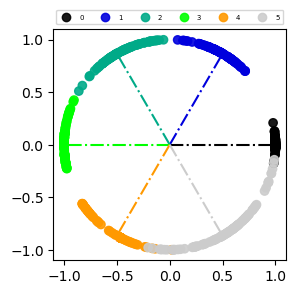

In [17]:
x, y = iter(testloader).next()
embedding, distance = net(x.to(device), normalize=True, return_embedding=True)
x = embedding
x1, x2, color = [], [], []
for i in range(len(y)):
    x1.append(x[i][0].item())
    x2.append(x[i][1].item())
    color.append(y[i].item())
plt.figure(figsize=(3,3))    
fig = plt.scatter(x1, x2, c=color, cmap=cm.nipy_spectral,alpha=0.9)
legend = plt.legend(*fig.legend_elements(), loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fancybox=True, prop={'size': 5})
centers = net.W.detach().cpu()
scale = 1
for i in range(centers.shape[0]):
    x1, x2 = [0.0, scale*centers[i][0].item()], [0.0, scale*centers[i][1].item()]
    plt.plot(x1, x2,  '-.', color=fig.to_rgba(i)) 